In [7]:
import scipy
import numpy as np
import matplotlib
import pandas as pd
import sklearn
import statsmodels
import bamboolib as bam
from statsmodels.tsa.seasonal import STL, seasonal_decompose
bam.disable()

The bamboolib extension was disabled. You can enable it again via 'bam.enable()'. In case that bamboolib was not helpful to you, we are sorry and would like to fix this. Please write us a quick mail to info@8080labs.com so that we can serve you better in the future. Best regards, Tobias and Florian


In [34]:
file_name = 'maregraphie_csv_4_2010-2022.csv'

In [35]:
from pandas import read_csv
data_ = read_csv(file_name, header=0, index_col=0, parse_dates=True, squeeze=True)

In [36]:
data = data_.drop(columns=['Source'])

In [45]:
dfcol = ['Valeur']
data = data.resample('H').mean()
data

,Valeur
Date,
2010-01-01 00:00:00,3.375
2010-01-01 01:00:00,4.768
2010-01-01 02:00:00,6.079
2010-01-01 03:00:00,7.033
2010-01-01 04:00:00,7.433
...,...
2022-12-06 19:00:00,2.235
2022-12-06 20:00:00,1.555
2022-12-06 21:00:00,1.576


array([<AxesSubplot:xlabel='Date'>], dtype=object)

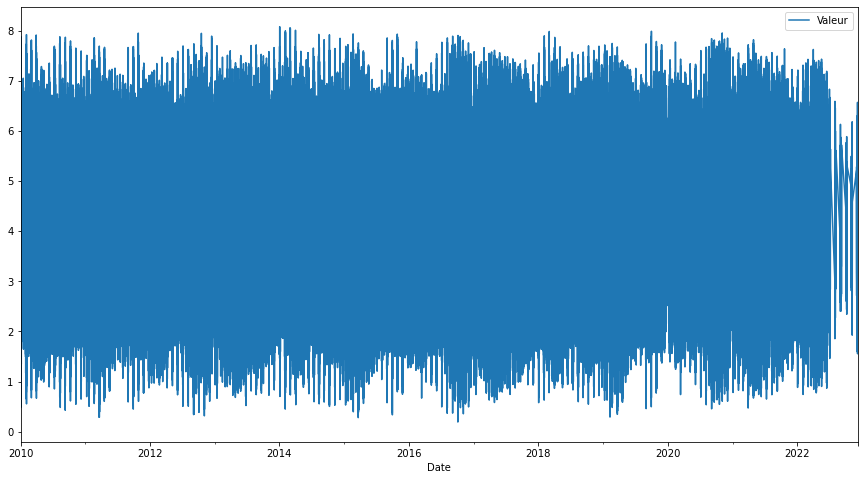

In [46]:
preprocessed = data.copy()
for key in preprocessed.keys():
    temp = preprocessed[key]
    nan_index = temp.isnull()
    temp = temp.interpolate('linear')
    results = seasonal_decompose(temp, period=24*30*12, model='additive', extrapolate_trend='freq')
    for i, real in enumerate(nan_index):
        if real == True:
            results.trend.iloc[i] = np.nan
            dt = str(results.resid.index[i])
            results.seasonal.iloc[i] = results.seasonal.loc[dt]
            results.resid.iloc[i] = results.resid.loc[dt]
            
    preprocessed[key] = results.trend.interpolate('linear') + results.seasonal + results.resid

preprocessed.plot(figsize=(15, 8), subplots=True)

In [47]:
# We have to separate de data for years.
# For this problem one year is like one cycle.
split1 = pd.to_datetime('2020/12/31 23:00:00')
split2 = pd.to_datetime('2021/01/01')
finish = pd.to_datetime('2022/06/30/ 22:00:00')

In [48]:
train = preprocessed[:split1]
test = preprocessed[split2:finish]

In [49]:
print(train)
print('-' * 50)
print(test)

                     Valeur
Date                       
2010-01-01 00:00:00   3.375
2010-01-01 01:00:00   4.768
2010-01-01 02:00:00   6.079
2010-01-01 03:00:00   7.033
2010-01-01 04:00:00   7.433
...                     ...
2020-12-31 19:00:00   5.456
2020-12-31 20:00:00   4.301
2020-12-31 21:00:00   3.174
2020-12-31 22:00:00   2.325
2020-12-31 23:00:00   1.890

[96432 rows x 1 columns]
--------------------------------------------------
                     Valeur
Date                       
2021-01-01 00:00:00   2.107
2021-01-01 01:00:00   3.003
2021-01-01 02:00:00   4.256
2021-01-01 03:00:00   5.529
2021-01-01 04:00:00   6.476
...                     ...
2022-06-30 18:00:00   6.125
2022-06-30 19:00:00   5.278
2022-06-30 20:00:00   4.244
2022-06-30 21:00:00   3.230
2022-06-30 22:00:00   2.423

[13103 rows x 1 columns]


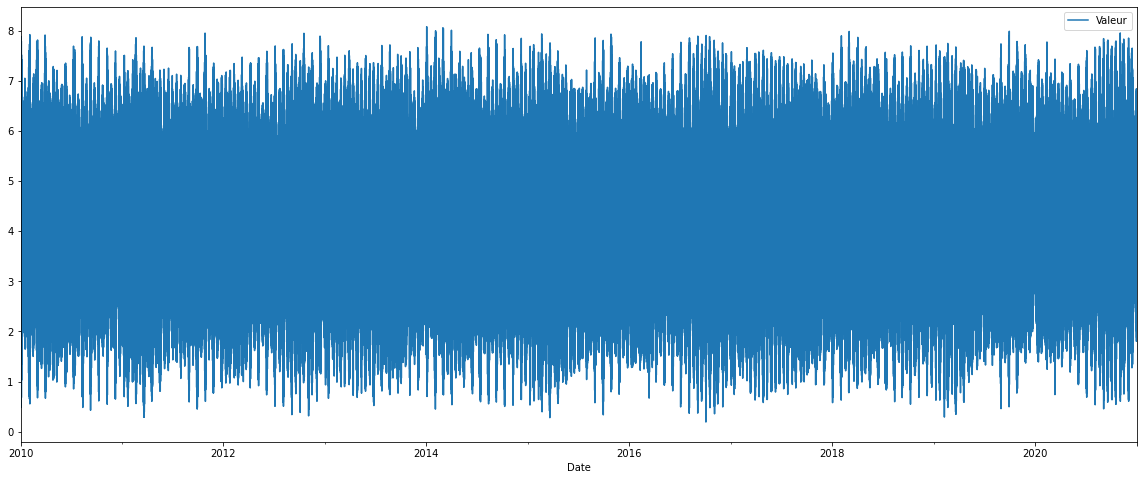

In [50]:
train.dropna(inplace=True)
test.dropna(inplace=True)
axes = train[dfcol].plot(figsize=(20, 8), subplots=True)

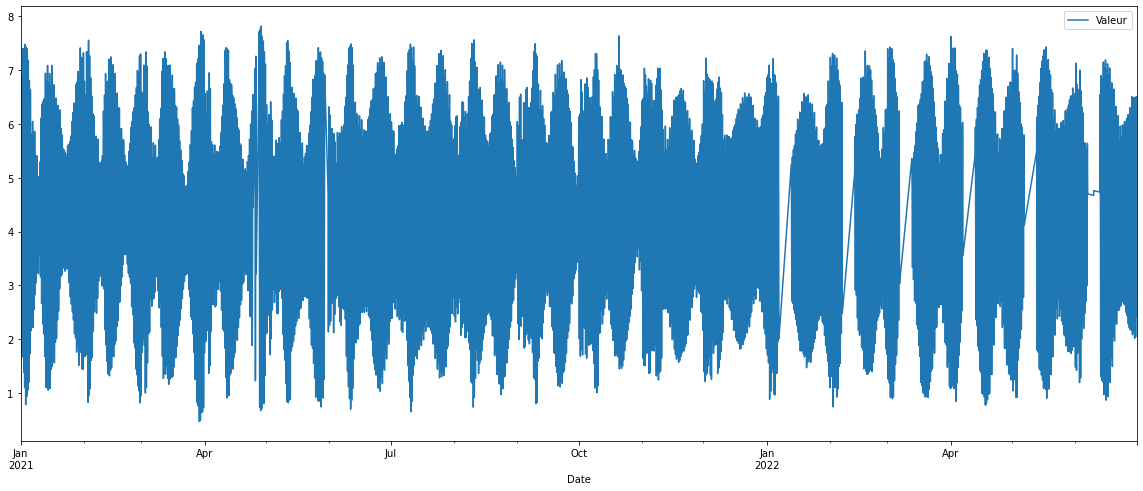

In [51]:
axes = test[dfcol].plot(figsize=(20, 8), subplots=True)

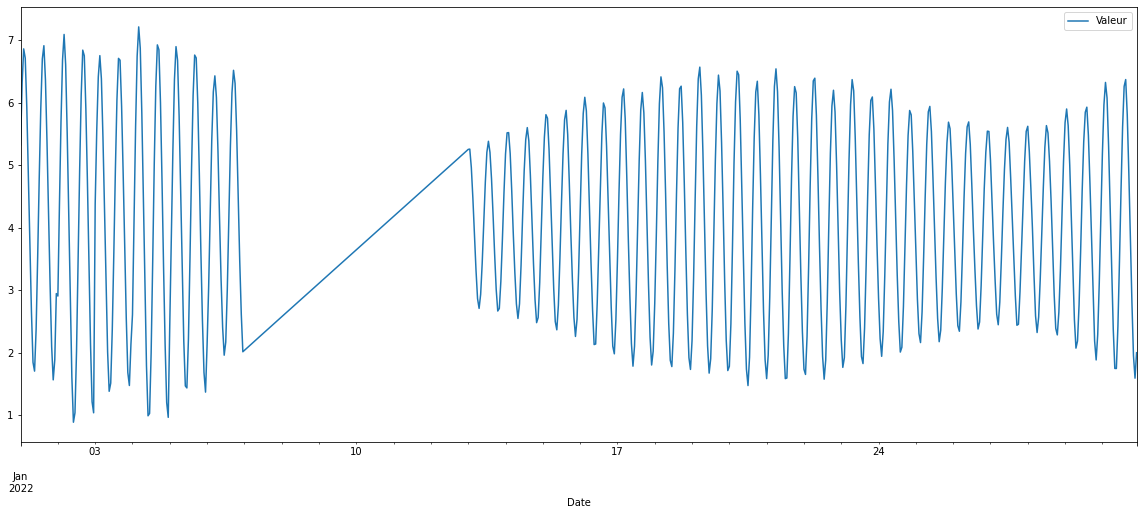

In [52]:
split_ = pd.to_datetime('2022/01/01/ 00:00:00')
finish_ = pd.to_datetime('2022/01/30/ 22:00:00')
test_2022 = preprocessed[split_:finish_]
axes = test_2022[dfcol].plot(figsize=(20, 8), subplots=True)

In [53]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

def timeseries_to_supervised(data, lag=1):
    """Frame a sequence data into a supervised learning problem, i.e., time sequence -> (X, y)"""
    df = DataFrame(data)  # DataFrame is a pandas class
    columns = [df.shift(i) for i in range(1, lag+1)]  # shift() pushed dataframe or a column vector downwards by i spaces
    columns.insert(0, df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)   # turn NaN to 0
    return df
# I haven't undertood this yet

In [54]:
train = timeseries_to_supervised(train, 24)
test = timeseries_to_supervised(test, 24)

In [55]:
test.to_csv('test.csv')
train.to_csv('train.csv')
train = read_csv('train.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
test = read_csv('test.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [56]:
test['Month'] = pd.DatetimeIndex(test.index).month
test['Hour'] = pd.DatetimeIndex(test.index).hour
test['Day'] = pd.DatetimeIndex(test.index).day

train['Month'] = pd.DatetimeIndex(train.index).month
train['Hour'] = pd.DatetimeIndex(train.index).hour
train['Day'] = pd.DatetimeIndex(train.index).day
train

,Valeur,Valeur.1,Valeur.2,Valeur.3,Valeur.4,Valeur.5,Valeur.6,Valeur.7,Valeur.8,Valeur.9,...,Valeur.18,Valeur.19,Valeur.20,Valeur.21,Valeur.22,Valeur.23,Valeur.24,Month,Hour,Day
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,3.375,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0,1
2010-01-01 01:00:00,4.768,3.375,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1,1
2010-01-01 02:00:00,6.079,4.768,3.375,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,2,1
2010-01-01 03:00:00,7.033,6.079,4.768,3.375,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,3,1
2010-01-01 04:00:00,7.433,7.033,6.079,4.768,3.375,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,5.456,6.376,6.754,6.460,5.611,4.393,3.141,2.162,1.803,2.147,...,3.805,2.688,2.038,2.097,2.735,3.707,4.825,12,19,31
2020-12-31 20:00:00,4.301,5.456,6.376,6.754,6.460,5.611,4.393,3.141,2.162,1.803,...,5.066,3.805,2.688,2.038,2.097,2.735,3.707,12,20,31
2020-12-31 21:00:00,3.174,4.301,5.456,6.376,6.754,6.460,5.611,4.393,3.141,2.162,...,6.146,5.066,3.805,2.688,2.038,2.097,2.735,12,21,31


In [57]:
# test1['Month'] = pd.DatetimeIndex(test1.index).month
# test1['Hour'] = pd.DatetimeIndex(test1.index).hour
# test1['Day'] = pd.DatetimeIndex(test1.index).day

# train1['Month'] = pd.DatetimeIndex(train1.index).month
# train1['Hour'] = pd.DatetimeIndex(train1.index).hour
# train1['Day'] = pd.DatetimeIndex(train1.index).day
# train1

,Valeur,Month,Hour,Day
Date,,,,
2010-01-01 00:00:00,3.375,1,0,1
2010-01-01 01:00:00,4.768,1,1,1
2010-01-01 02:00:00,6.079,1,2,1
2010-01-01 03:00:00,7.033,1,3,1
2010-01-01 04:00:00,7.433,1,4,1
...,...,...,...,...
2020-12-31 19:00:00,5.456,12,19,31
2020-12-31 20:00:00,4.301,12,20,31
2020-12-31 21:00:00,3.174,12,21,31


In [59]:
test = test.loc[(test['Hour'] == 0) | (test['Hour'] == 12)]
# test1 = test1.loc[(test1['Hour'] == 0) | (test1['Hour'] == 12)]

In [60]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()

Y_train = train.filter(dfcol, axis=1)
X_train = train.drop(columns=dfcol)
X_train = sc_X.fit_transform(X_train)
Y_train = sc_y.fit_transform(Y_train)

Y_test = test.filter(dfcol, axis=1)
X_test = test.drop(columns=dfcol)
X_test = sc_X.fit_transform(X_test)
Y_test = sc_y.fit_transform(Y_test)

In [82]:
test.drop(columns=dfcol)

,Valeur.1,Valeur.2,Valeur.3,Valeur.4,Valeur.5,Valeur.6,Valeur.7,Valeur.8,Valeur.9,Valeur.10,...,Valeur.18,Valeur.19,Valeur.20,Valeur.21,Valeur.22,Valeur.23,Valeur.24,Month,Hour,Day
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0,1
2021-01-01 12:00:00,1.878,2.567,3.538,4.709,5.848,6.665,6.884,6.476,5.529,4.256,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,12,1
2021-01-02 00:00:00,2.067,2.812,3.821,4.981,6.035,6.655,6.599,5.958,4.855,3.551,...,6.665,6.884,6.476,5.529,4.256,3.003,2.107,1,0,2
2021-01-02 12:00:00,2.603,3.754,5.082,6.375,7.255,7.402,6.827,5.673,4.207,2.780,...,6.655,6.599,5.958,4.855,3.551,2.400,1.756,1,12,2
2021-01-03 00:00:00,3.052,4.224,5.470,6.524,7.055,6.859,6.024,4.709,3.233,1.980,...,7.402,6.827,5.673,4.207,2.780,1.810,1.671,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-28 12:00:00,2.699,2.174,2.307,2.917,3.770,4.711,5.578,6.154,6.173,5.663,...,4.442,5.365,6.087,6.303,5.974,5.234,4.248,6,12,28
2022-06-29 00:00:00,2.312,2.082,2.470,3.244,4.195,5.188,6.044,6.505,6.372,5.705,...,4.711,5.578,6.154,6.173,5.663,4.767,3.725,6,0,29
2022-06-29 12:00:00,2.213,2.125,2.606,3.402,4.377,5.347,6.097,6.339,6.001,5.211,...,5.188,6.044,6.505,6.372,5.705,4.703,3.630,6,12,29


In [77]:
X_test

array([[-2.31877781, -2.42484864, -2.64165299, ..., -1.36862393,
        -1.        , -1.67284189],
       [-1.0547539 , -0.66428118, -0.18671565, ..., -1.36862393,
         1.        , -1.67284189],
       [-0.92754383, -0.49624884,  0.00965159, ..., -1.36862393,
        -1.        , -1.55889832],
       ...,
       [-0.82927573, -0.96742525, -0.83340914, ...,  0.1434535 ,
         1.        ,  1.51757812],
       [-0.95985115, -0.92147355, -0.69185821, ...,  0.1434535 ,
        -1.        ,  1.63152169],
       [-0.94437056, -0.83094183, -0.54406237, ...,  0.1434535 ,
         1.        ,  1.63152169]])

In [61]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

mod = MultiOutputRegressor(SVR(kernel='rbf'), n_jobs=4)
model1 = mod.fit(X_train,Y_train)

In [62]:
y_pred = model1.predict(X_test)
y_new_inverse = sc_y.inverse_transform(y_pred)
y_inverse = sc_y.inverse_transform(Y_test)

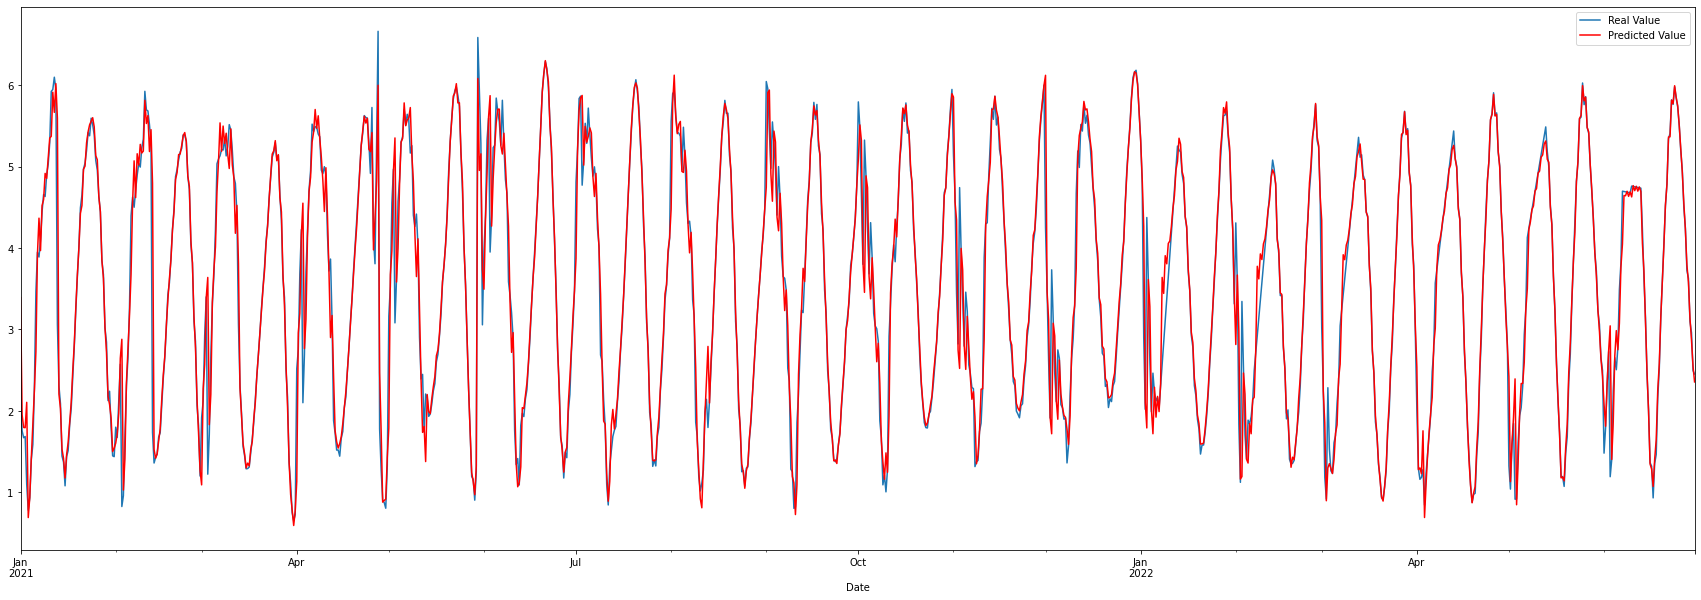

In [63]:
import matplotlib.pyplot as plt

test_dates = test.index
y_df = pd.DataFrame(y_inverse)
y_n_df = pd.DataFrame(y_new_inverse)
y_df.columns = dfcol
y_n_df.columns = dfcol
y_n_df.index = test_dates
y_df.index = test_dates
axes = y_df[dfcol].plot(figsize=(30, 10), subplots=True)
y_n_df[dfcol].plot(figsize=(30, 10), subplots=True, ax = axes, color='red')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('prediction_2021_2022.png')

In [64]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import max_error

def stats_model(model_num, plot_df, pred_df, num_target=1):
    """
    Function for predictions metrics
    """
    rmse = list()  # Mean Squared Error
    mse = list()  # root-mean-square error
    rsq2 = list()  # coefficient of determination
    MedAE = list()  # median_absolute_error
    MAE = list()  # mean_absolute_error
    MaxErr = list()  # max_error

    
    for i in range(0,num_target):
        m = mean_squared_error(plot_df.iloc[:,i], pred_df.iloc[:,i])
        rmse.append(np.sqrt(m))
        mse.append(m)
        rsq2.append(r2_score(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        MAE.append(mean_absolute_error(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        MedAE.append(median_absolute_error(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        MaxErr.append(max_error(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        

    results = pd.DataFrame(mse)
    results.insert(1, 'RMSE', rmse) 
    results.insert(2, 'R^2', rsq2)
    results.insert(3, 'MAE', MAE)
    results.insert(4, 'MedAE', MedAE)
    results.insert(5, 'MaxErr', MaxErr)
    results.rename(columns = {0:'MSE'}, inplace = True) 
    results.to_csv('Model'+str(model_num)+'.csv')

In [65]:
stats_model(1, y_df, y_n_df, 1)

In [66]:
model1 = read_csv('Model1.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [67]:
model1

,MSE,RMSE,R^2,MAE,MedAE,MaxErr
0,0.130566,0.361339,0.942309,0.158102,0.052407,3.056119


In [73]:
# https://stackoverflow.com/questions/56634647/create-an-hourly-series-of-a-year
year = 2023
dates_2023 = pd.Series(pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31 23:00:00', freq='H'))
dates_2023

0      2023-01-01 00:00:00
1      2023-01-01 01:00:00
2      2023-01-01 02:00:00
3      2023-01-01 03:00:00
4      2023-01-01 04:00:00
               ...        
8755   2023-12-31 19:00:00
8756   2023-12-31 20:00:00
8757   2023-12-31 21:00:00
8758   2023-12-31 22:00:00
8759   2023-12-31 23:00:00
Length: 8760, dtype: datetime64[ns]